In [ ]:
!pip install ta
!pip install xgboost

import ta
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Data Extraction

In [2]:
np.random.seed(1111)

df = pd.read_csv('Database.csv')
df

,Date,Open,High,Low,Close,Volume,Return,Output
0,04/01/2010 16:56:00,5.87,5.92,5.69,5.87,449800,-0.08,0
1,05/01/2010 16:56:00,5.87,6.04,5.77,5.95,817700,-0.47,0
2,06/01/2010 16:56:00,5.98,6.51,5.96,6.42,1077000,0.27,1
3,07/01/2010 16:56:00,6.37,6.37,6.09,6.15,425400,-0.05,0
4,08/01/2010 16:56:00,6.15,6.34,6.04,6.20,366600,-0.04,0
...,...,...,...,...,...,...,...,...
3319,24/08/2023 16:56:00,66.15,66.48,65.40,65.45,6201500,2.52,1
3320,25/08/2023 16:56:00,65.45,65.60,62.69,62.93,5148500,0.15,1
3321,28/08/2023 16:56:00,63.19,63.24,62.04,62.78,4100600,-0.78,0
3322,29/08/2023 16:56:00,63.00,64.20,62.87,63.56,3955100,0.17,1


In [3]:
#df2 = pd.read_csv('Database2.csv')
#df2 = df2[['Return', 'Output']]
#df_d = pd.concat([df,df2],axis=1)
#df_one = pd.get_dummies(df_d['tendencia_1'])
#df_d = pd.concat([df, df_one], axis=1)

#dataDates = pd.to_datetime(df['Date'], errors='coerce')
#df = df.drop(["tendencia_1", "tendencia_2", "tendencia_3"], axis=1)
#df["year"] = dataDates.dt.year
#df

In [4]:
dataDates = pd.to_datetime(df['Date'], errors='coerce')

df["year"] =  dataDates.dt.year
df

,Date,Open,High,Low,Close,Volume,Return,Output,year
0,04/01/2010 16:56:00,5.87,5.92,5.69,5.87,449800,-0.08,0,2010
1,05/01/2010 16:56:00,5.87,6.04,5.77,5.95,817700,-0.47,0,2010
2,06/01/2010 16:56:00,5.98,6.51,5.96,6.42,1077000,0.27,1,2010
3,07/01/2010 16:56:00,6.37,6.37,6.09,6.15,425400,-0.05,0,2010
4,08/01/2010 16:56:00,6.15,6.34,6.04,6.20,366600,-0.04,0,2010
...,...,...,...,...,...,...,...,...,...
3319,24/08/2023 16:56:00,66.15,66.48,65.40,65.45,6201500,2.52,1,2023
3320,25/08/2023 16:56:00,65.45,65.60,62.69,62.93,5148500,0.15,1,2023
3321,28/08/2023 16:56:00,63.19,63.24,62.04,62.78,4100600,-0.78,0,2023
3322,29/08/2023 16:56:00,63.00,64.20,62.87,63.56,3955100,0.17,1,2023


## Feature Engineering

### Time Series Feature



In [5]:
open = df.Open
high = df.High
low = df.Low
close = df.Close
volume = df.Volume

In [6]:
# Close Lag Feature
df['Close_Lag_1'] = close.shift(1)

# Volume difference
df['Volume_diff'] = volume.diff()

# Volume Weighted Average Price
df['vwap'] = (close * volume).cumsum() / volume.cumsum()

# Volume Percentage Change
df['volume_percentage_change'] = volume.pct_change()

# Daily Return
df['daily_Return'] = close.pct_change() * 100

In [7]:
interators = [2, 3, 4, 5, 10]

for interator in interators:

    # Lag Feature
    close_lag_column = f"Close_Lag_{interator}"
    df[close_lag_column] = close.shift(interator)

    # Rolling Avg
    rolling_averages = df.rolling(interator).mean()
    close_rolling_mean_column = f"Close_Rolling_Mean_{interator}"
    df[close_rolling_mean_column] = rolling_averages["Close"]

    # Close Ratio
    close_ratio_column = f"Close_Ratio_{interator}"
    df[close_ratio_column] = close / rolling_averages["Close"]

    # Rolling Standard Deviation
    rolling_std = df.rolling(interator).std()
    close_rolling_std_column = f"Close_Rolling_Std_{interator}"
    df[close_rolling_std_column] = rolling_std["Close"]

    # Expanding Avg
    expanding_averages = df.expanding(interator).mean()
    close_expanding_mean_column = f"Close_Expanding_Mean_{interator}"
    df[close_expanding_mean_column] = expanding_averages["Close"]

    # Expanding Standard Deviation
    expanding_std = df.expanding(interator).std()
    close_expanding_std_column = f"Close_Expanding_Mean_{interator}"
    df[close_expanding_std_column] = expanding_std["Close"]

    # Exponential Moving Avg
    exponential_mov_avg = df.ewm(span=interator, adjust=False).mean()
    exponential_moving_avg_column = f"Exponential_Moving_Avg_{interator}"
    df[exponential_moving_avg_column] = exponential_mov_avg["Close"]

    # Simple Moving Average
    sma = df.rolling(interator).mean()
    sma_mean_column = f"sma_{interator}"
    df[sma_mean_column] = sma["Close"]

<ipython-input-7-c6832f42c335>:10: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolling_averages = df.rolling(interator).mean()
<ipython-input-7-c6832f42c335>:19: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  rolling_std = df.rolling(interator).std()
<ipython-input-7-c6832f42c335>:24: FutureWarning: Dropping of nuisance columns in rolling operations is deprecated; in a future version this will raise TypeError. Select only valid columns before calling the operation. Dropped columns were Index(['Date'], dtype='object')
  expanding_averages = df.expanding(interator).mean()
<ipython-input-7-c6832f42c335>:29: F

In [8]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()
df.head()

,Date,Open,High,Low,Close,Volume,Return,Output,year,Close_Lag_1,...,Close_Expanding_Mean_5,Exponential_Moving_Avg_5,sma_5,Close_Lag_10,Close_Rolling_Mean_10,Close_Ratio_10,Close_Rolling_Std_10,Close_Expanding_Mean_10,Exponential_Moving_Avg_10,sma_10
10,18/01/2010 16:56:00,6.56,6.68,6.48,6.61,370300,-0.02,0,2010,6.41,...,0.230391,6.458262,6.472,5.87,6.332,1.043904,0.193437,0.230391,6.338106,6.332
11,19/01/2010 16:56:00,6.59,6.71,6.48,6.63,798300,0.26,1,2010,6.61,...,0.240599,6.515508,6.514,5.95,6.400,1.035937,0.161038,0.240599,6.391178,6.400
12,20/01/2010 16:56:00,6.60,6.65,6.36,6.37,641600,0.24,1,2010,6.63,...,0.230801,6.467005,6.498,6.42,6.395,0.996091,0.161125,0.230801,6.387327,6.395
13,21/01/2010 16:56:00,6.45,6.53,6.06,6.13,684600,0.01,1,2010,6.37,...,0.227625,6.354670,6.430,6.15,6.393,0.958861,0.164590,0.227625,6.340540,6.393
14,22/01/2010 16:56:00,6.06,6.16,5.97,6.12,688000,-0.06,0,2010,6.13,...,0.224684,6.276447,6.372,6.20,6.385,0.958496,0.176525,0.224684,6.300442,6.385


### Technical Indicator Feature

In [9]:
# Moving Average Convergence Divergence (MACD)
df['MACD'] = ta.trend.macd_diff(df['Close'])

# Relative Strength Index (RSI)
df['RSI_5'] = ta.momentum.rsi(df['Close'], window=5)
df['RSI_14'] = ta.momentum.rsi(df['Close'], window=14)

# Money Flow Multiplier: [(Close - Low) - (High - Close)] /(High - Low)
money_flow_mult = ((close - low) - (high - close)) /(high - low)
df['money_flow_mult'] = money_flow_mult

# Money Flow Volume: Money Flow Multiplier x Volume for the Period
money_flow_volume = money_flow_mult * volume
df['money_flow_volume'] = money_flow_volume

# ADL(ADI): Previous ADL + Current Period's Money Flow Volume
adi = money_flow_volume.cumsum()
df['adi'] = adi

# Chaikin Money Flow
cmf = money_flow_volume.rolling(20).sum() / volume.rolling(20).sum()
df['chaikin_money_flow'] = cmf

In [10]:
df = df.replace([np.inf, -np.inf], np.nan)
df = df.dropna()

df.head()

,Date,Open,High,Low,Close,Volume,Return,Output,year,Close_Lag_1,...,Close_Expanding_Mean_10,Exponential_Moving_Avg_10,sma_10,MACD,RSI_5,RSI_14,money_flow_mult,money_flow_volume,adi,chaikin_money_flow
43,09/03/2010 16:56:00,5.95,6.14,5.87,6.08,583300,0.01,1,2010,5.93,...,0.244513,5.999138,5.987,0.018214,59.721023,51.026089,0.555556,324055.555556,-4.953375e+05,0.064261
44,10/03/2010 16:56:00,6.09,6.15,6.02,6.07,309200,0.10,1,2010,6.08,...,0.241731,6.012022,6.006,0.021761,58.312843,50.656062,-0.230769,-71353.846154,-5.666913e+05,0.108964
45,11/03/2010 16:56:00,5.97,6.05,5.96,5.97,246300,0.05,1,2010,6.07,...,0.239641,6.004381,6.020,0.017001,45.038221,46.986624,-0.777778,-191566.666667,-7.582580e+05,0.096629
46,12/03/2010 16:56:00,5.99,6.01,5.88,5.92,494000,0.05,1,2010,5.97,...,0.238218,5.989039,6.019,0.010437,39.428421,45.222703,-0.384615,-190000.000000,-9.482580e+05,0.061770
47,15/03/2010 16:56:00,5.96,5.99,5.87,5.87,178500,-0.04,0,2010,5.92,...,0.237611,5.967396,5.994,0.003062,34.116617,43.465451,-1.000000,-178500.000000,-1.126758e+06,-0.014307


In [11]:
df.drop(["Date"], axis=1)

,Open,High,Low,Close,Volume,Return,Output,year,Close_Lag_1,Volume_diff,...,Close_Expanding_Mean_10,Exponential_Moving_Avg_10,sma_10,MACD,RSI_5,RSI_14,money_flow_mult,money_flow_volume,adi,chaikin_money_flow
43,5.95,6.14,5.87,6.08,583300,0.01,1,2010,5.93,142100.0,...,0.244513,5.999138,5.987,0.018214,59.721023,51.026089,0.555556,3.240556e+05,-4.953375e+05,0.064261
44,6.09,6.15,6.02,6.07,309200,0.10,1,2010,6.08,-274100.0,...,0.241731,6.012022,6.006,0.021761,58.312843,50.656062,-0.230769,-7.135385e+04,-5.666913e+05,0.108964
45,5.97,6.05,5.96,5.97,246300,0.05,1,2010,6.07,-62900.0,...,0.239641,6.004381,6.020,0.017001,45.038221,46.986624,-0.777778,-1.915667e+05,-7.582580e+05,0.096629
46,5.99,6.01,5.88,5.92,494000,0.05,1,2010,5.97,247700.0,...,0.238218,5.989039,6.019,0.010437,39.428421,45.222703,-0.384615,-1.900000e+05,-9.482580e+05,0.061770
47,5.96,5.99,5.87,5.87,178500,-0.04,0,2010,5.92,-315500.0,...,0.237611,5.967396,5.994,0.003062,34.116617,43.465451,-1.000000,-1.785000e+05,-1.126758e+06,-0.014307
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3319,66.15,66.48,65.40,65.45,6201500,2.52,1,2023,66.32,-2844300.0,...,20.892549,64.852500,64.401,0.046634,57.402945,48.217861,-0.907407,-5.627287e+06,4.147431e+08,-0.025954
3320,65.45,65.60,62.69,62.93,5148500,0.15,1,2023,65.45,-1053000.0,...,20.899356,64.502955,64.041,-0.043226,36.261787,39.192314,-0.835052,-4.299263e+06,4.104439e+08,-0.092129
3321,63.19,63.24,62.04,62.78,4100600,-0.78,0,2023,62.93,-1047900.0,...,20.906071,64.189690,63.900,-0.098714,35.294615,38.727626,0.233333,9.568067e+05,4.114007e+08,-0.099968
3322,63.00,64.20,62.87,63.56,3955100,0.17,1,2023,62.78,-145500.0,...,20.913193,64.075201,63.765,-0.070173,44.854975,42.542628,0.037594,1.486880e+05,4.115494e+08,-0.119420


## Evaluate

In [12]:
from sklearn.metrics import recall_score, precision_score, accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import mean_squared_error, mean_absolute_error

def evaluate_classification(y_test, y_pred):
  cm = confusion_matrix(y_test, y_pred)

  ConfusionMatrixDisplay(confusion_matrix=cm).plot();

  accuracy = accuracy_score(y_test, y_pred)
  precision = precision_score(y_test, y_pred)
  recall = recall_score(y_test, y_pred)
  AUC = roc_auc_score(y_test, y_pred)

  print("Accuracy:", accuracy)
  print("Precision:", precision)
  print("Recall:", recall)
  print("AUC:", AUC)


def evaluate_regressor(y_test, y_pred):
  test_set_rmse = np.sqrt(mean_squared_error(y_test, y_pred))
  print('RMSE = ', test_set_rmse)

  mae = mean_absolute_error(y_test, y_pred)
  print("MAE = ", mae)

## Generate Output

In [13]:
def generate_output(y_test, y_pred):
  date = df.loc[df['year'] >= 2022, ['Date', 'Output']].reset_index()
  date = pd.to_datetime(date['Date']).dt.strftime('%Y%m%d')
  date = pd.DataFrame(date)

  pred = pd.DataFrame(y_pred, columns = ['Prediction'])

  output = pd.concat([date, pred], axis=1)
  output.to_csv('output.csv', index=False)

  return output

# Random Forest

## Split Dataset

In [ ]:
y_test_aux = df.loc[df['year'] >= 2022, ['Date', 'Output']].reset_index()

y_train = df.loc[df['year'] < 2022, 'Output']
X_train = df.loc[df['year']  < 2022].drop(['Output', 'Return', 'Date'], axis="columns")

y_test = df.loc[df['year']  >= 2022, 'Output']
X_test = df.loc[df['year']  >= 2022].drop(['Output', 'Return', 'Date'], axis="columns")

## Holdout

In [ ]:
from sklearn.ensemble import RandomForestClassifier

# Aplica Random Forest Classification para o conjunto de treinamento
classifier = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1111)
classifier.fit(X_train, y_train)

# Predição com os o conjunto de teste
y_pred = classifier.predict(X_test)


Accuracy: 0.5035971223021583
Precision: 0.5175438596491229
Recall: 0.2796208530805687
AUC: 0.5063152809092164


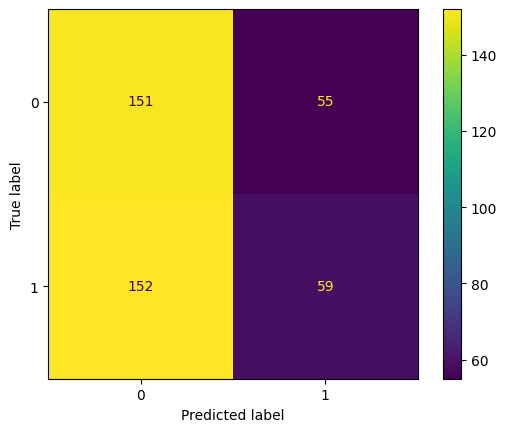

In [ ]:
evaluate_classification(y_test, y_pred)

In [ ]:
generate_output(y_test,y_pred)

## Time Series Split

In [ ]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler

def expanding_window(model, X_train, y_train, window_size):

    pred = []
    actuals = []

    size = len(df.loc[df['year'] < 2022].index)
    size_max =  len(df)

    train_starts = range(size, size_max, window_size)
    i = 0

    for train_start in train_starts:

        X_train_window, X_test_window = X_train[:train_start], X_train[train_start : train_start + window_size]
        y_train_window, y_test_window = y_train[:train_start], y_train[train_start : train_start + window_size]

        print(f"Fold: {i}")
        #print(f"Train: index={X_train[:train_start].index} - Size: {X_train[:train_start].size}")
        #print(f"Test:  index={y_train[train_start : train_start + window_size].index} - Size: {y_train[train_start : train_start + window_size].size} \n")

        model.fit(X_train_window, y_train_window)
        y_pred_window = model.predict(X_test_window)

        i+=1
        pred.extend(y_pred_window)
        actuals.extend(y_test_window)

    return np.array(pred), np.array(actuals)


In [ ]:
y = df['Output']
X = df.drop(['Output', 'Return', 'Date'], axis="columns")

### Time Series Split (22 Days)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=22)

In [ ]:
evaluate_classification(y_test_window, y_pred_window)

In [ ]:
generate_output(y_test_window, y_pred_window)

### Time Series Split (5 Days)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=5)

In [ ]:
evaluate_classification(y_test_window, y_pred_window)

In [ ]:
generate_output(y_test_window, y_pred_window)

### Time Series Split (1 Days)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
classifier = RandomForestClassifier(random_state=1111)
y_pred_window, y_test_window = expanding_window(classifier, X, y, window_size=1)

In [ ]:
evaluate_classification(y_test_window, y_pred_window)

In [ ]:
generate_output(y_test_window, y_pred_window)

## Baseline Classification

In [ ]:
y_train = df.loc[df['year'] < 2022, 'Output']
X_train = df.loc[df['year'] < 2022].drop(['Output', 'Return'], axis="columns")

y_test = df.loc[df['year'] >= 2022, 'Output']
X_test = df.loc[df['year'] >= 2022].drop(['Output', 'Return'], axis="columns")

In [ ]:
y_pred_base_classifier = pd.DataFrame(y_test)
y_pred_base_classifier.value_counts()

Output
1         211
0         206
dtype: int64

In [ ]:
y_pred_base_classifier['Output'] = 1
y_pred_base_classifier

,Output
2907,1
2908,1
2909,1
2910,1
2911,1
...,...
3319,1
3320,1
3321,1
3322,1


Accuracy: 0.5059952038369304
Precision: 0.5059952038369304
Recall: 1.0
AUC: 0.5


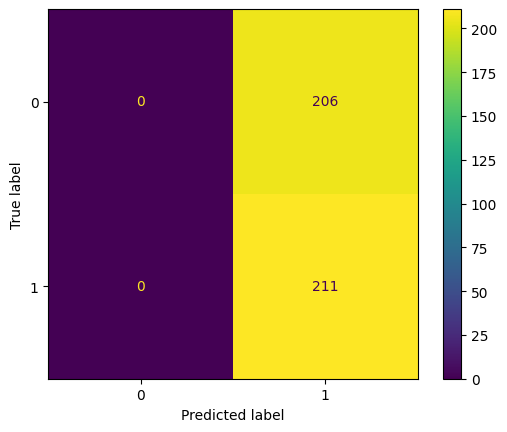

In [ ]:
evaluate_classification(y_test, y_pred_base_classifier)

# MLP (Regression)

In [ ]:
y_test_aux = df.loc[df['year'] >= 2022, ['Date', 'Output']].reset_index()

y_train = df.loc[df['year'] < 2022, 'Return']
X_train = df.loc[df['year']  < 2022].drop(['Output', 'Return', 'Date'], axis="columns")

y_test = df.loc[df['year'] >= 2022, 'Return']
X_test = df.loc[df['year'] >= 2022].drop(['Output', 'Return', 'Date'], axis="columns")

## Holdout

In [ ]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [ ]:
from sklearn.neural_network import MLPRegressor

# Aplica MLP para o conjunto de treinamento
regressor = MLPRegressor(random_state=1111)
regressor.fit(X_train, y_train)

# Predição com os o conjunto de teste
y_pred = regressor.predict(X_test)

In [ ]:
# Avalia
evaluate_regressor(y_test, y_pred)

In [ ]:
generate_output(y_test, y_pred)

## Time Series Split

In [ ]:
y = df['Return']
X = df.drop(['Output', 'Return', 'Date'], axis="columns")

### Time Series Split (22 Days)

In [ ]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

In [ ]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(hidden_layer_sizes=(1), max_iter=100, random_state=1111)
y_pred_window, y_test_window = expanding_window(regressor, X, y, window_size=22)

In [ ]:
evaluate_regressor(y_test_window, y_pred_window)

In [ ]:
generate_output(y_test_window, y_pred_window)

### Time Series Split (5 Days)

In [ ]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state=1111)
y_pred_window, y_test_window = expanding_window(regressor, X, y, window_size=5)

In [ ]:
evaluate_regressor(y_test_window, y_pred_window)

In [ ]:
generate_output(y_test_window, y_pred_window)

### Time Series Split (1 Days)

In [ ]:
from sklearn.neural_network import MLPRegressor

regressor = MLPRegressor(random_state=1111)
y_pred_window, y_test_window = expanding_window(regressor, X, y, window_size=1)

In [ ]:
evaluate_regressor(y_test_window, y_pred_window)

In [ ]:
generate_output(y_test_window, y_pred_window)



```
# This is formatted as code
```

## Baseline Regression

In [ ]:
y_test_aux = df.loc[df['year'] >= 2022, ['Date', 'Output']].reset_index()

y_train = df.loc[df['year'] < 2022, 'Output']
X_train = df.loc[df['year']  < 2022].drop(['Output', 'Return', 'Date'], axis="columns")

y_test = df.loc[df['year'] >= 2022, 'Return']
X_test = df.loc[df['year'] >= 2022].drop(['Output', 'Return', 'Date'], axis="columns")

In [ ]:
y_pred_base_regressor = pd.DataFrame(y_test).shift(1, fill_value=0)
y_pred_base_regressor

In [ ]:
evaluate_regressor(y_test, y_pred_base_regressor)

# Ensemble Classification

In [14]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.metrics import roc_auc_score

def get_models_classification():
    """Cria lista com modelos base"""
    models = list()
    models.append(('RandomForest', RandomForestClassifier(random_state=22)))
    models.append(('MLP', MLPClassifier(random_state=22)))
    models.append(('XGBoost', XGBClassifier(random_state=22)))
    models.append(('NaiveBayes', GaussianNB()))
    models.append(('KNN', KNeighborsClassifier()))

    return models

def evaluate_models(models, X_train, X_val, y_train, y_val):
    """Treina e avalia cada um dos modelos base e retorna suas pontuações AUC e previsões dos modelos"""

    scores = list()
    predictions = []

    # Treina e avalia os modelos
    for name, model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
        predictions.append(y_pred)

        print(f"{name}: {auc}\n")

    return scores, predictions

In [15]:
# Divide o Conjunto de Dados em subconjuntos de treinamento e teste
y_test_aux = df.loc[df['year'] >= 2022, ['Date', 'Output']].reset_index()

y_train_full = df.loc[df['year'] < 2022, 'Output']
X_train_full = df.loc[df['year']  < 2022].drop(['Output', 'Return', 'Date'], axis="columns")

y_test = df.loc[df['year']  >= 2022, 'Output']
X_test = df.loc[df['year']  >= 2022].drop(['Output', 'Return', 'Date'], axis="columns")

# Divide o Conjunto de Dados em subconjuntos de treinamento e validação
y_train = df.loc[df['year'] < 2021, 'Output']
X_train = df.loc[df['year']  < 2021].drop(['Output', 'Return', 'Date'], axis="columns")

y_val = df.loc[(df['year']  >= 2021) & (df['year']  < 2022), 'Output']
X_val = df.loc[(df['year']  >= 2021) & (df['year']  < 2022)].drop(['Output', 'Return', 'Date'], axis="columns")

# Cria os modelos base
models = get_models_classification()

## Votação

Accuracy: 0.5275779376498801
Precision: 0.5228758169934641
Recall: 0.7582938388625592
AUC: 0.5247779873924446


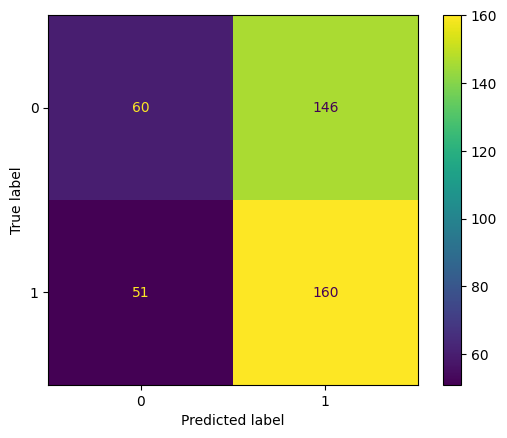

In [ ]:
# Cria a técnica de Ensemble de Votação
voting = VotingClassifier(estimators=models)

# Aplica Votação para o conjunto de Treinamento
voting.fit(X_train_full, y_train_full)

# Faz previsões no conjunto de Teste
y_pred = voting.predict(X_test)

# Avalia as predições
evaluate_classification(y_test, y_pred)

In [ ]:
generate_output(y_test,y_pred)

,Date,Prediction
0,20220301,0
1,20220401,1
2,20220501,0
3,20220601,0
4,20220701,0
...,...,...
412,20230824,0
413,20230825,0
414,20230828,1
415,20230829,1


## Média

Accuracy: 0.5467625899280576
Precision: 0.563953488372093
Recall: 0.4597156398104265
AUC: 0.5478189849537569


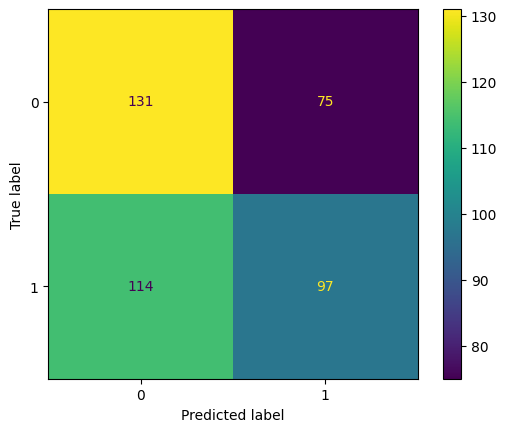

In [16]:
# Cria a técnica de Ensemble por Média
average = VotingClassifier(estimators=models, voting='soft')

# Aplica Média para o conjunto de Treinamento
average.fit(X_train_full, y_train_full)

# Faz previsões no conjunto de Teste
y_pred = average.predict(X_test)

# Avalia as predições
evaluate_classification(y_test, y_pred)

In [116]:
generate_output(y_test,y_pred)

,Date,Prediction
0,20220301,0
1,20220401,1
2,20220501,0
3,20220601,0
4,20220701,0
...,...,...
412,20230824,0
413,20230825,0
414,20230828,0
415,20230829,0


## Média Ponderada

RandomForest: 0.5115384615384615

MLP: 0.4931623931623932

XGBoost: 0.5594017094017093

NaiveBayes: 0.5158119658119659

KNN: 0.49102564102564106

Accuracy: 0.5491606714628298
Precision: 0.5608465608465608
Recall: 0.5023696682464455
AUC: 0.5497285234436111


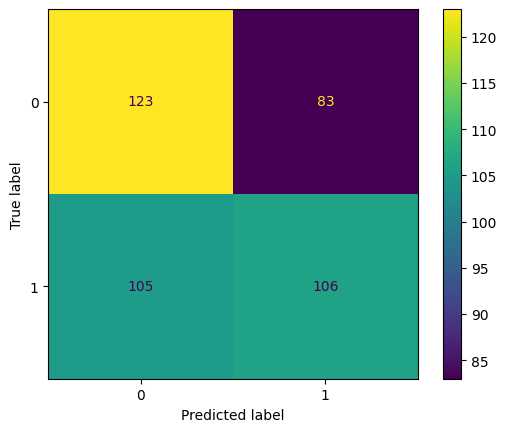

In [17]:
# Calcula as pontuações AUC e previsões dos modelos
scores, pred = evaluate_models(models, X_train, X_val, y_train, y_val)

# Cria a técnica de Ensemble por Média Ponderada
weighted_average = VotingClassifier(estimators=models, voting='soft', weights=scores)

# Aplica Média Ponderada para o conjunto de Treinamento
weighted_average.fit(X_train_full, y_train_full)

# Faz previsões no conjunto de Teste
y_pred = weighted_average.predict(X_test)

# Avalia as predições
evaluate_classification(y_test, y_pred)

In [91]:
generate_output(y_test,y_pred)

,Date,Prediction
0,20220301,1
1,20220401,1
2,20220501,0
3,20220601,1
4,20220701,1
...,...,...
412,20230824,1
413,20230825,1
414,20230828,1
415,20230829,1


## Stacking

In [24]:
# Calcula as pontuações AUC e previsões dos modelos com o conjunto de validação
scores, pred = evaluate_models(models, X_train, X_val, y_train, y_val)

# Gera DataFrame com as saídas dos modelos individuais
df_stacking = pd.DataFrame(data=np.transpose(pred), columns=['RandomForest', 'MLP', 'XGBoost', 'NaiveBayes', 'KNN'])
df_stacking['Output'] = pd.DataFrame(y_val).reset_index().drop(['index'], axis=1)

y_train_stacking = df_stacking['Output']
X_train_stacking = df_stacking.drop(['Output'], axis="columns")

# Cria a técnica de Stacking
stacking = MLPClassifier(random_state=22)

# Aplica Stacking para o conjunto de validação
stacking.fit(X_train_stacking, y_train_stacking)

RandomForest: 0.5115384615384615

MLP: 0.4931623931623932

XGBoost: 0.5594017094017093

NaiveBayes: 0.5158119658119659

KNN: 0.49102564102564106



/usr/local/lib/python3.10/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


MLPClassifier(random_state=22)

RandomForest: 0.5147816684304974

MLP: 0.5070514885197626

XGBoost: 0.5225233515851471

NaiveBayes: 0.5063958036166198

KNN: 0.535993650209359

Accuracy: 0.5083932853717026
Precision: 0.5101351351351351
Recall: 0.7156398104265402
AUC: 0.5058781576404545


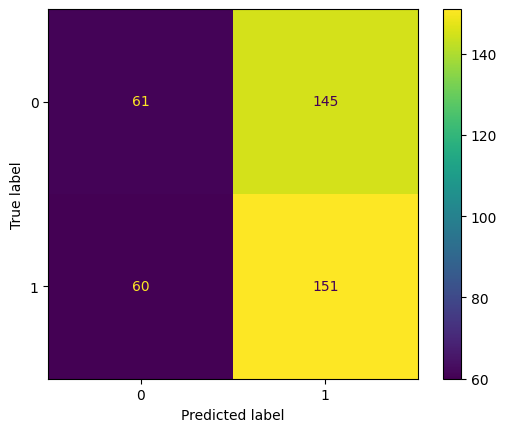

In [25]:
# Calcula as pontuações AUC e previsões dos modelos com o conjunto de teste
scores, pred = evaluate_models(models, X_train_full, X_test, y_train_full, y_test)

# Faz previsões no conjunto de Teste
X_test_stacking = pd.DataFrame(data=np.transpose(pred), columns=['RandomForest', 'MLP', 'XGBoost', 'NaiveBayes', 'KNN'])
y_pred_stacking = stacking.predict(X_test_stacking)

# Avalia as predições
evaluate_classification(y_test, y_pred_stacking)

In [27]:
generate_output(y_test, y_pred_stacking)

,Date,Prediction
0,20220301,1
1,20220401,0
2,20220501,1
3,20220601,0
4,20220701,1
...,...,...
412,20230824,1
413,20230825,1
414,20230828,1
415,20230829,1


# Ensemble Regression

In [28]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.metrics import roc_auc_score

def get_models_regression():
  """Cria lista com modelos base"""
  models = list()
  models.append(('RandomForest', RandomForestRegressor(random_state=22)))
  models.append(('MLP', MLPRegressor(random_state=22)))
  models.append(('XGBoost', XGBRegressor(random_state=22)))
  #models.append(('NaiveBayes', GaussianNB()))
  models.append(('KNN', KNeighborsRegressor()))

  return models

# evaluate each base model
def evaluate_models_regression(models, X_train, X_val, y_train, y_val):

  """Treina e avalia cada um dos modelos base e retorna suas pontuações AUC e previsões dos modelos"""

  scores, pred = list(), list()

  # Treina e avalia os modelos
  for name, model in models:
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    mae = 1/(mean_absolute_error(y_val, y_pred))
    scores.append(mae)
    pred.append(y_pred)

    print(f"{name}: {mae}\n")

  return scores, pred

In [29]:
# Divide o Conjunto de Dados em subconjuntos de treinamento e teste
y_test_aux = df.loc[df['year'] >= 2022, ['Date', 'Return']].reset_index()

y_train_full = df.loc[df['year'] < 2022, 'Return']
X_train_full = df.loc[df['year']  < 2022].drop(['Output', 'Return', 'Date'], axis="columns")

y_test = df.loc[df['year']  >= 2022, 'Return']
X_test = df.loc[df['year']  >= 2022].drop(['Output', 'Return', 'Date'], axis="columns")

# Divide o Conjunto de Dados em subconjuntos de treinamento e validação
y_train = df.loc[df['year'] < 2021, 'Return']
X_train = df.loc[df['year']  < 2021].drop(['Output', 'Return', 'Date'], axis="columns")

y_val = df.loc[(df['year']  >= 2021) & (df['year']  < 2022), 'Return']
X_val = df.loc[(df['year']  >= 2021) & (df['year']  < 2022)].drop(['Output', 'Return', 'Date'], axis="columns")

# Cria os modelos base
models = get_models_regression()

In [30]:
# Feature Scaling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train_full = sc.fit_transform(X_train_full)
X_test = sc.transform(X_test)

## Média

In [31]:
# Cria a técnica de Ensemble por Média
average = VotingRegressor(estimators=models)

# Aplica Média para o conjunto de Treinamento
average.fit(X_train_full, y_train_full)

# Faz previsões no conjunto de Teste
y_pred = average.predict(X_test)

# Avalia as predições
evaluate_regressor(y_test, y_pred)

RMSE =  1.389731674044984
MAE =  1.0766153529600835


In [32]:
generate_output(y_test,y_pred)

,Date,Prediction
0,20220301,-0.345472
1,20220401,0.114892
2,20220501,-0.227349
3,20220601,-0.238605
4,20220701,-0.369939
...,...,...
412,20230824,0.008257
413,20230825,-0.201802
414,20230828,-0.097480
415,20230829,-0.018033


## Média Ponderada

In [ ]:
# Calcula as pontuações AUC e previsões dos modelos
scores, pred = evaluate_models_regression(models, X_train, X_val, y_train, y_val)

# Cria a técnica de Ensemble por Média Ponderada
weighted_average = VotingRegressor(estimators=models, weights=scores)

# Aplica Média Ponderada para o conjunto de Treinamento
weighted_average.fit(X_train_full, y_train_full)

# Faz previsões no conjunto de Teste
y_pred = weighted_average.predict(X_test)

# Avalia as predições
evaluate_regressor(y_test, y_pred)

In [34]:
generate_output(y_test,y_pred)

,Date,Prediction
0,20220301,-0.170199
1,20220401,0.463411
2,20220501,-0.187250
3,20220601,0.049936
4,20220701,-0.123619
...,...,...
412,20230824,0.279872
413,20230825,0.057029
414,20230828,0.170416
415,20230829,0.243177


## Stacking

In [37]:
# Calcula as pontuações AUC e previsões dos modelos com o conjunto de validação
scores, pred = evaluate_models_regression(models, X_train, X_val, y_train, y_val)

# Gera DataFrame com as saídas dos modelos individuais
df_stacking = pd.DataFrame(data=np.transpose(pred), columns=['RandomForest', 'MLP', 'XGBoost', 'KNN'])
df_stacking['Output'] = pd.DataFrame(y_val).reset_index().drop(['index'], axis=1)

y_train_stacking = df_stacking['Output']
X_train_stacking = df_stacking.drop(['Output'], axis="columns")

# Cria a técnica de Stacking
stacking = MLPRegressor(random_state=22)

# Aplica Stacking para o conjunto de validação
stacking.fit(X_train_stacking, y_train_stacking)

RandomForest: 0.8525263946658772

MLP: 0.00020384292954574992

XGBoost: 0.6794820354052313

KNN: 0.5175180921810766



MLPRegressor(random_state=22)

In [41]:
# Calcula as pontuações AUC e previsões dos modelos com o conjunto de teste
scores, pred = evaluate_models_regression(models, X_train_full, X_test, y_train_full, y_test)

# Faz previsões no conjunto de Teste
X_test_stacking = pd.DataFrame(data=np.transpose(pred), columns=['RandomForest', 'MLP', 'XGBoost', 'KNN'])
y_pred_stacking = stacking.predict(X_test_stacking)

# Avalia as predições
evaluate_regressor(y_test, y_pred_stacking)

RandomForest: 0.8291186468783684

MLP: 0.8997576324575284

XGBoost: 0.7631472188556662

KNN: 0.8670303897270418

RMSE =  1.3100101229938386
MAE =  1.0091619368937905


In [42]:
generate_output(y_test, y_pred_stacking)

,Date,Prediction
0,20220301,-0.338589
1,20220401,-0.026127
2,20220501,-0.385583
3,20220601,-0.143378
4,20220701,-0.262433
...,...,...
412,20230824,-0.287595
413,20230825,-0.203224
414,20230828,-0.125121
415,20230829,-0.193855
